# 耕地质量等级评价

## 一、确定评价单元
以三调底图种同一土地利用类型、同一村级行政区在按照同一土类划分评价单元。

## 二、确定所评价区域的指标
参照耕地质量评价技术指南。

## 三、连接属性
参照耕地质量评价技术指南选定评价区域所需属性链接至单元（一般以单元覆盖区域均值求取）。

## 四、计算耕地质量综合指数
采用累加法计算:$$P= \sum(C_i \times F_i)$$

式中:$P$代表耕地质量综合指数，
    $C_i$代表第i个评价指标的组合权重，
    $F_i$代表第i个评价指标的隶属度。

## 五、耕地质量等级划分
获得综合指数以后，按照技术指南等级划分指数做等级划分。

## 六、耕地质量生产潜力评估
#### 1.年度粮食产能水平
$$ y=
\begin{cases} 
y_{\min}, & u \leq u_1 \\
\frac{b}{{1 + a(u-c)^2}}, & u_1 < u \leq u_2\\
y_{\max}, & u \geq u_2 
\end{cases}
$$
式中：y为某一评价单元全年耕地粮食产能水平，$y_{\min}$为最低等级地综合指数平均值计算的产能水平，$y_{\max}$为最高等级地综合指数平均值计算的产能水平，u为综合指数得分，u1为最低等级地综合指数平均值，u2为最高等级地综合指数平均值，a、b为系数，c为标准值。
#### 2.单季粮食产能水平
$$Y_1 = y/m$$
式中：$Y_1$为某一评价单元打击耕地粮食产能水平，$y$为区域年度耕地粮食产能水平，$m$为当地熟制。
#### 3. 年度粮食生产潜力
$$Y_2 = y \cdot s \cdot k$$
式中：$Y_2$为区域年度耕地粮食生产潜力，$y$为区域年度耕地粮食产能水平，$s$为区域面积，$k$为校正系数（区域耕地种粮面积及与区域耕地面积的比值）。

拟合系数计算：
```python
import numpy as np
from scipy.optimize import curve_fit
# 提供的数据点
scores = np.array([0.89, 0.87, 0.84, 0.82, 0.79, 0.77, 0.74, 0.72])
yields = np.array([1200, 1100, 1000, 900, 800, 700, 600, 500])
# 定义戒上型函数模型
def upper_bound_model(x, a, c, b):
    return b / (1 + a * (x - c)**2)
# 更新初始参数猜测: 我们可以尝试将a的初始值设为更小的数值，c设为评分的中间值
updated_initial_guess = [0.01, np.mean(scores), max(yields)]

# 更新curve_fit的参数，增加最大迭代次数 maxfev
params, params_covariance = curve_fit(
    upper_bound_model, scores, yields, 
    p0=updated_initial_guess, 
    maxfev=1000  # 增加最大迭代次数
)
# 输出拟合的参数
a_fit, c_fit, b_fit = params
a_fit, c_fit, b_fit
```


# 七、计算示例
示例数据中各评价单元已连接所需指标。

In [80]:
# type:ignore
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
data_path = r"G:\soil_property_result\qzs\grade_evaluation\table\grade_evaluation_have_index.csv"

In [81]:
data_frame = pd.read_csv(data_path)
data_frame.columns

Index(['FID', 'DLMC', 'ZLDWDM', 'ZLDWMC', 'Class1', 'Class1_ts', 'Class1_yl',
       'Class1_tl', 'DLBM', 'QSDWDM', 'QSDWMC', 'DLLB', 'DLDM', 'MZMC',
       'gridcode', 'project_Area', '酸碱度', '有机质', '速效钾', '有效磷', '土壤容重', '耕层厚度',
       '有效土层厚度', '海拔高度', '地形部位', '灌溉能力', '排水能力', '耕层质地', '质地构型'],
      dtype='object')

In [82]:
data_frame.sample(1)

,FID,DLMC,ZLDWDM,ZLDWMC,Class1,Class1_ts,Class1_yl,Class1_tl,DLBM,QSDWDM,...,有效磷,土壤容重,耕层厚度,有效土层厚度,海拔高度,地形部位,灌溉能力,排水能力,耕层质地,质地构型
59302,59302,水田,5201812032120000000,洛阳村,石灰泥田,灰泥田,潴育水稻土,水稻土,1,5201812032120000000,...,9.26,1.27,13.74,111.09,1212.58,山地坡下,满足,不满足,壤质黏土,紧实型


In [83]:
# 1、获取该地区所需的评价指标。
# 打开 JSON 文件并加载内容
with open(r'D:\worker_code\Terrain_Test\data\grade_evaluation\region_all.json', 'r', encoding='utf-8') as file:
    dictionary_data = json.load(file)

In [84]:
index_level = dictionary_data['西南区']['黔桂高原山地林农牧区']['权重'].keys()
print(index_level)
print(data_frame.columns)
print(set(index_level)-set(data_frame.columns)) # 检查是否缺少指标参数

dict_keys(['地形部位', '灌溉能力', '有效土层厚度', '有机质', '耕层质地', '酸碱度', '土壤容重', '海拔高度', '速效钾', '排水能力', '有效磷', '质地构型', '耕层厚度'])
Index(['FID', 'DLMC', 'ZLDWDM', 'ZLDWMC', 'Class1', 'Class1_ts', 'Class1_yl',
       'Class1_tl', 'DLBM', 'QSDWDM', 'QSDWMC', 'DLLB', 'DLDM', 'MZMC',
       'gridcode', 'project_Area', '酸碱度', '有机质', '速效钾', '有效磷', '土壤容重', '耕层厚度',
       '有效土层厚度', '海拔高度', '地形部位', '灌溉能力', '排水能力', '耕层质地', '质地构型'],
      dtype='object')
set()


In [85]:
## 隶属度计算
## 概念型指标
gn_value = dictionary_data['西南区']['黔桂高原山地林农牧区']['隶属度函数']['概念型']
print(gn_value)

{'地形部位': {'山间盆地': 0.86, '宽谷盆地': 0.95, '平原低阶': 1.0, '平原中阶': 0.94, '平原高阶': 0.85, '丘陵上部': 0.62, '丘陵中部': 0.77, '丘陵下部': 0.84, '山地坡上': 0.47, '山地坡中': 0.65, '山地坡下': 0.75}, '质地构型': {'海绵型': 1.0, '夹层型': 0.9, '紧实型': 0.65, '松散型': 0.7, '薄层型': 0.5, '上松下紧型': 0.35, '上紧下松型': 0.3}, '耕层质地': {'壤土': 1.0, '粉(砂)质壤土': 0.9, '黏壤土': 0.85, '粉(砂)质黏壤土': 0.8, '粉(砂)质黏土': 0.7, '砂质黏壤土': 0.83, '砂质壤土': 0.76, '壤质黏土': 0.73, '黏土': 0.6, '砂质黏土': 0.7, '重黏土': 0.52, '砂土及壤质砂土': 0.47}, '灌溉能力': {'充分满足': 1.0, '满足': 0.85, '基本满足': 0.7, '不满足': 0.4}, '排水能力': {'充分满足': 1.0, '满足': 0.85, '基本满足': 0.7, '不满足': 0.45}}


In [86]:
# 计算概念性指标
for one_index in gn_value:
    print(f"计算{one_index}")
    data_frame[f'{one_index}_sub'] = data_frame[one_index].map(gn_value[one_index])

计算地形部位
计算质地构型
计算耕层质地
计算灌溉能力
计算排水能力


In [87]:
# 定义一个计算函数，根据函数类型选择对应的公式进行计算
def calculate_value(row, value):
    """注:公式中y为隶属度;a为系数;b为截距;c为标准指标:u为实测值。
    当函数类型为负直线型,u小于等于下限值时y为1;u大于等于上限值时,y为0;
    当函数类型为戒上型,u小于等于下限值时,y为0;u大于等于上限值时,y为1;
    当函数类型为峰型,u小于等于下限值或u大于等于上限值时,y为0。"""
    function_type = row['类型']
    a = row.get('系数a', None)
    b = row.get('截距b', None)
    c = row.get('标准值c', None)
    u_min = row.get('最小值', None)
    u_max = row.get('最大值', None)
    
    if function_type == '负直线型':
        return np.where(value <= u_min, 1,
               np.where(value >= u_max, 0,
               b - a * value))
    elif function_type == '戒上型':
        return np.where(value <= u_min, 0,
               np.where(value >= u_max, 1,
               1 / (1 + a * (value-c) ** 2)))
    elif function_type == '峰型':
        return np.where((value <= u_min) | (value >= u_max), 0,
               1 / (1 + a * (value-c) ** 2))
    else:
        return None

In [88]:
## 数值型指标
sz_value = dictionary_data['西南区']['黔桂高原山地林农牧区']['隶属度函数']['数值型']
sz_value

{'海拔高度': {'类型': '负直线型',
  '公式': 'y=b-au',
  '表达式': 'y=1.042457-0.000302u',
  '系数a': 0.000302,
  '截距b': 1.042457,
  '最小值': 300.0,
  '最大值': 3446.5},
 '有效土层厚度': {'类型': '戒上型',
  '公式': 'y=1/(1+a(u-c)^2)',
  '表达式': 'y=1/(1+0.000478(u-91.652186)^2)',
  '系数a': 0.000478,
  '标准值c': 91.652186,
  '最小值': 5,
  '最大值': 91.6},
 '土壤容重': {'类型': '峰型',
  '公式': 'y=1/(1+a(u-c)^2)',
  '表达式': 'y=1/(1+7.708057(u-1.122518)^2)',
  '系数a': 7.708057,
  '标准值c': 1.122518,
  '最小值': 0.5,
  '最大值': 1.8},
 '酸碱度': {'类型': '峰型',
  '公式': 'y=1/(1+a(u-c)^2)',
  '表达式': 'y=1/(1+0.312760(u-6.686935)^2)',
  '系数a': 0.31276,
  '标准值c': 6.686935,
  '最小值': 3.0,
  '最大值': 9.5},
 '有机质': {'类型': '戒上型',
  '公式': 'y=1/(1+a(u-c)^2)',
  '表达式': 'y=1/(1+0.002657(u-36.824713)^2)',
  '系数a': 0.002657,
  '标准值c': 36.824713,
  '最小值': 2,
  '最大值': 36.8},
 '速效钾': {'类型': '戒上型',
  '公式': 'y=1/(1+a(u-c)^2)',
  '表达式': 'y=1/(1+0.000072(u-187.581753)^2)',
  '系数a': 7.2e-05,
  '标准值c': 187.581753,
  '最小值': 10,
  '最大值': 187},
 '有效磷': {'类型': '戒上型',
  '公式': 'y=1/(1+a(u-c

In [89]:
# 计算数值型指标
for one_index in sz_value:
    data_frame[f'{one_index}_sub'] = calculate_value(sz_value[one_index],data_frame[one_index])

In [90]:
## 计算综合指数
index_value = dictionary_data['西南区']['黔桂高原山地林农牧区']['权重']
index_value

{'地形部位': 0.1367,
 '灌溉能力': 0.1314,
 '有效土层厚度': 0.075,
 '有机质': 0.0738,
 '耕层质地': 0.0736,
 '酸碱度': 0.0671,
 '土壤容重': 0.0648,
 '海拔高度': 0.0646,
 '速效钾': 0.0644,
 '排水能力': 0.0643,
 '有效磷': 0.0642,
 '质地构型': 0.064,
 '耕层厚度': 0.0561}

In [91]:
values_dict = {key + '_sub': value for key, value in index_value.items()}
values_dict

{'地形部位_sub': 0.1367,
 '灌溉能力_sub': 0.1314,
 '有效土层厚度_sub': 0.075,
 '有机质_sub': 0.0738,
 '耕层质地_sub': 0.0736,
 '酸碱度_sub': 0.0671,
 '土壤容重_sub': 0.0648,
 '海拔高度_sub': 0.0646,
 '速效钾_sub': 0.0644,
 '排水能力_sub': 0.0643,
 '有效磷_sub': 0.0642,
 '质地构型_sub': 0.064,
 '耕层厚度_sub': 0.0561}

In [92]:
# 选择要计算权重的列
columns_to_calculate = values_dict.keys()
columns_to_calculate

dict_keys(['地形部位_sub', '灌溉能力_sub', '有效土层厚度_sub', '有机质_sub', '耕层质地_sub', '酸碱度_sub', '土壤容重_sub', '海拔高度_sub', '速效钾_sub', '排水能力_sub', '有效磷_sub', '质地构型_sub', '耕层厚度_sub'])

In [93]:
data_frame['综合指数'] = (data_frame[columns_to_calculate]*pd.Series(values_dict)).sum(axis=1)

In [94]:
data_frame['综合指数'].describe()

count   60191.00
mean        0.73
std         0.04
min         0.60
25%         0.70
50%         0.73
75%         0.76
max         0.86
Name: 综合指数, dtype: float64

In [95]:
# 等级划分
# 获取划分指数
level_value = dictionary_data['西南区']['黔桂高原山地林农牧区']['等级划分']
level_value

[{'最小值': 0.838, '最大值': 1.0, '等级': '一等'},
 {'最小值': 0.8105, '最大值': 0.838, '等级': '二等'},
 {'最小值': 0.783, '最大值': 0.8105, '等级': '三等'},
 {'最小值': 0.7555, '最大值': 0.783, '等级': '四等'},
 {'最小值': 0.728, '最大值': 0.7555, '等级': '五等'},
 {'最小值': 0.7005, '最大值': 0.728, '等级': '六等'},
 {'最小值': 0.673, '最大值': 0.7005, '等级': '七等'},
 {'最小值': 0.6455, '最大值': 0.673, '等级': '八等'},
 {'最小值': 0.618, '最大值': 0.6455, '等级': '九等'},
 {'最小值': 0.0, '最大值': 0.618, '等级': '十等'}]

In [96]:
# 等级划分函数
def calc_level(value):
    for level_dict in level_value:
        if level_dict['最小值'] <= value < level_dict['最大值']:
            return level_dict['等级']
    return None

In [97]:
data_frame['综合质量等级'] = data_frame['综合指数'].apply(calc_level)

In [98]:
data_frame['综合质量等级'].value_counts()

综合质量等级
六等    16200
五等    13390
四等    10131
七等     9372
三等     4216
八等     3704
九等     1670
二等     1289
一等      110
十等      109
Name: count, dtype: int64

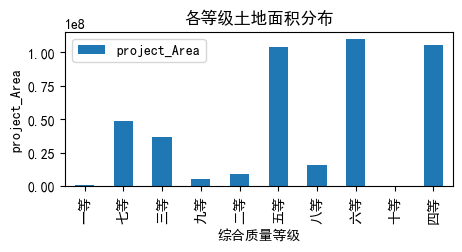

In [99]:

level_area = data_frame.groupby('综合质量等级')['project_Area'].sum().reset_index()

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 绘制
ax = level_area.plot(kind='bar', x='综合质量等级', y='project_Area', figsize=(5, 2))
plt.xlabel('综合质量等级')
plt.ylabel('project_Area')
plt.title('各等级土地面积分布')
plt.show()

In [100]:
# 导出等级质量评价表
save_path = r'G:\soil_property_result\qzs\grade_evaluation\result'
data_frame['QSDWDM'] = data_frame['QSDWDM'].astype(str)
data_frame['ZLDWDM'] = data_frame['ZLDWDM'].astype(str)
data_frame.to_excel(os.path.join(save_path,'grade_evaluation_result.xlsx'),index=False)

In [101]:
## 计算年度粮食产能
data_frame['综合质量等级'].value_counts()

综合质量等级
六等    16200
五等    13390
四等    10131
七等     9372
三等     4216
八等     3704
九等     1670
二等     1289
一等      110
十等      109
Name: count, dtype: int64

In [102]:
result_frame = data_frame.groupby('综合质量等级').agg({'project_Area': 'sum', '综合指数': 'mean'}).reset_index()
result_frame

,综合质量等级,project_Area,综合指数
0,一等,576074.17,0.85
1,七等,48729868.54,0.69
2,三等,36675266.77,0.79
3,九等,5185457.08,0.63
4,二等,9168920.20,0.82
5,五等,104251221.17,0.74
6,八等,15703988.56,0.66
7,六等,109816268.19,0.71
8,十等,277397.35,0.61
9,四等,105844985.32,0.77


In [103]:
# 产量录入
yield_dict = {"一等":1500,"二等":1478,"三等":1320,"四等":1218,"五等":1116,"六等":1018,"七等":996,"八等":826,"九等":735,"十等":665,}
result_frame['预估产量'] = result_frame['综合质量等级'].map(yield_dict)
result_frame


,综合质量等级,project_Area,综合指数,预估产量
0,一等,576074.17,0.85,1500
1,七等,48729868.54,0.69,996
2,三等,36675266.77,0.79,1320
3,九等,5185457.08,0.63,735
4,二等,9168920.20,0.82,1478
5,五等,104251221.17,0.74,1116
6,八等,15703988.56,0.66,826
7,六等,109816268.19,0.71,1018
8,十等,277397.35,0.61,665
9,四等,105844985.32,0.77,1218


In [104]:
# 计算模拟系数
# type:ignore
from scipy.optimize import curve_fit
def fit_upper_bound_model(scores, yields):
    """
    scores: 评分数据 (numpy 数组)
    yields: 预估产量数据 (numpy 数组)
    返回拟合结果 (a 值, c 值, 固定的 b 值)
    """
    # 定义戒上型函数模型，将参数 b 从参数列表中移除
    def upper_bound_model(x, a, c):
        b = max(yields)  # 固定 b 值为 yields 中的最大值
        return b / (1 + a * (x - c)**2)
    # 更新初始参数猜测: 我们可以尝试将 a 的初始值设为更小的数值，c 设为评分的中间值
    updated_initial_guess = [0.01, np.mean(scores)]
    # 更新 curve_fit 的参数，增加最大迭代次数 maxfev
    params, params_covariance = curve_fit(
        upper_bound_model, scores, yields, 
        p0=updated_initial_guess, 
        maxfev=1000  # 增加最大迭代次数
    )
    # 输出拟合的参数
    a_fit, c_fit = params
    fixed_b = max(yields)  # 固定的 b 值
    return a_fit, c_fit, fixed_b

In [105]:
coe = fit_upper_bound_model(result_frame['综合指数'],result_frame['预估产量'])
print(f"系数a: {coe[0]:.2f},  系数c: {coe[1]:.2f},  系数b: {coe[2]}")

系数a: 17.97,  系数c: 0.87,  系数b: 1500


In [106]:
# 计算产量上限和下限
max_ = result_frame['预估产量'].max() / (1+coe[0]*(result_frame['综合指数'].max()-coe[1]) ** 2)
min_ = result_frame['预估产量'].min() / (1+coe[0]*(result_frame['综合指数'].min()-coe[1]) ** 2)
print(f"上限：{max_:.2f},下限：{min_:.2f}")

上限：1478.43,下限：300.33


In [107]:
# 计算每个地块对应的预测产能
# 产能计算函数
def calc_yields(value):
    if value > result_frame['综合指数'].max():
        return max_
    elif value < result_frame['综合指数'].min():
        return min_
    else:
        temp_value = coe[2] / (1 + coe[0] * (value - coe[1]) ** 2)
        return temp_value

In [108]:
# 得到单个地块产能
data_frame['预测产能'] = data_frame['综合指数'].apply(calc_yields)

In [109]:
# 得到单个地块产量，面积为公顷换位亩，即乘15
data_frame['产量'] = data_frame['预测产能']*data_frame['project_Area']*15

In [110]:
# 单季粮食产能水平（这里以一年两熟为例）
data_frame['单季粮食产能水平'] = data_frame['预测产能'] / 2

In [111]:
# 区域年度粮食生产潜力
pd.set_option('display.float_format', '{:.2f}'.format)
dj_result = data_frame.groupby('综合质量等级').agg({'project_Area':'sum','产量':'sum'}).reset_index()
dj_result

,综合质量等级,project_Area,产量
0,一等,576074.17,12753263190.49
1,七等,48729868.54,683829070420.67
2,三等,36675266.77,739978653954.62
3,九等,5185457.08,57934629418.06
4,二等,9168920.20,196124909714.20
5,五等,104251221.17,1789844905737.50
6,八等,15703988.56,194277455651.36
7,六等,109816268.19,1698880053371.96
8,十等,277397.35,2431215257.58
9,四等,105844985.32,1978763950844.30


In [112]:
# 计算校正系数K（计算系数=实际播种面积/理论耕地平差面积/播种季数）
# 实际应用中，实际播种面积从年鉴资料获取，播种季数按地区指定。（这里实际面积按平差面积80%计算，季数取2。）
k_index = (dj_result['project_Area'].sum() * 15 * 0.8) /  (dj_result['project_Area'].sum() * 15) / 2
k_index

0.4

In [113]:
# 计算区域耕地年度粮食生产潜力
yields_ability = dj_result['产量'].sum()*k_index
yields_ability

2941927243024.294

In [114]:
# 将结果保存
data_frame.to_excel(os.path.join(save_path,'grade_evaluation_result_have_channeng.xlsx'),index=False)